                                        ┌─────────────────────────┐
                                        │  Input: Ortholog Sequences │
                                        └────────────┬────────────┘
                                                        │
                                                        ▼
                                        ┌─────────────────────────┐
                                        │ Compute similarity to   │
                                        │  human TP53 (identity) │
                                        └────────────┬────────────┘
                                                        │
                                                        ▼
                                        ┌─────────────────────────┐
                                        │ Unsupervised Clustering │
                                        │       (KMeans)         │
                                        │   Labels: Close/Distant│
                                        └────────────┬────────────┘
                                                        │
                                                        ▼
                                        ┌─────────────────────────┐
                                        │ Feature Extraction      │
                                        │ (Amino Acid Composition │
                                        │   per sequence)         │
                                        └────────────┬────────────┘
                                                        │
                                                        ▼
                                        ┌─────────────────────────┐
                                        │ Supervised Learning     │
                                        │ (RandomForest)          │
                                        │ Train to predict Close/ │
                                        │ Distant for new seqs    │
                                        └────────────┬────────────┘
                                                        │
                                                        ▼
                                        ┌─────────────────────────┐
                                        │  Predictions for new    │
                                        │  sequences: Close/Distant│
                                        │  Probabilities          │
                                        └─────────────────────────┘
                                        

Clustered similarity table saved as tp53_similarity_clusters.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_16020\564862938.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


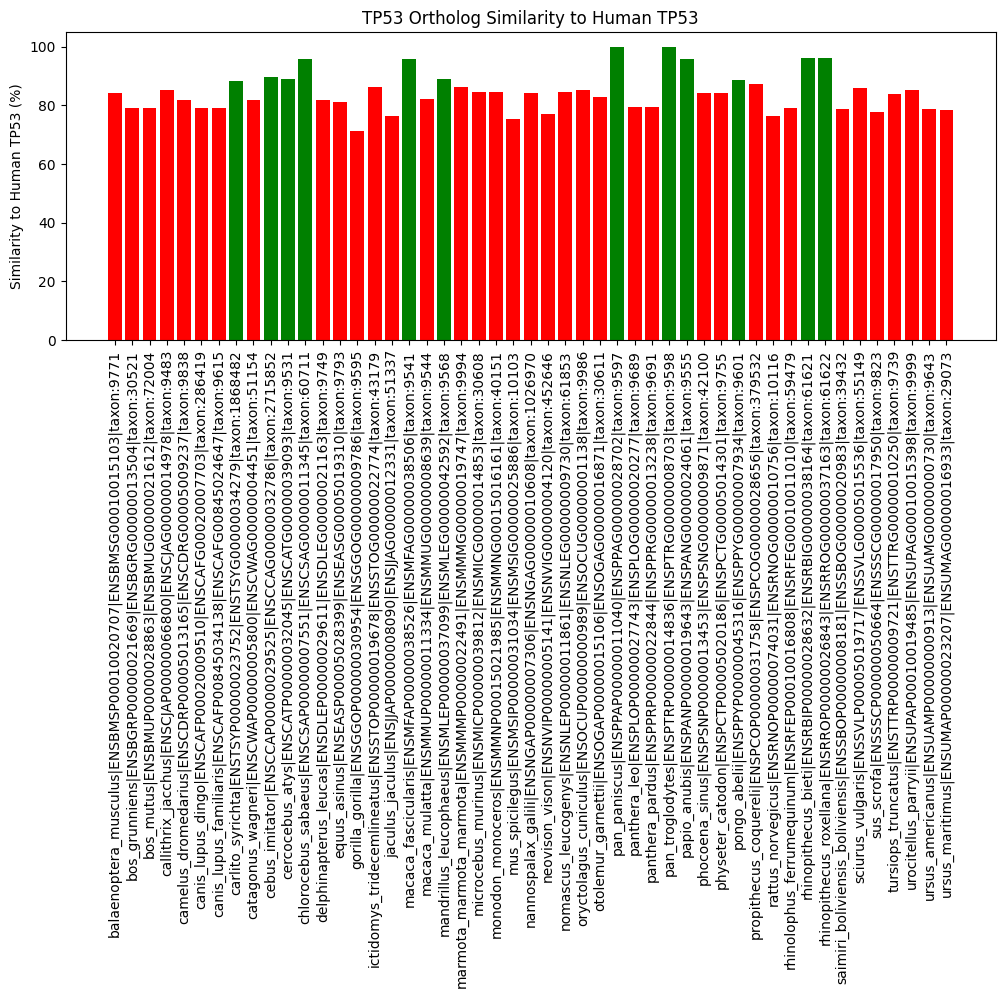

Saved 12 'Close' sequences to close_sequences.fasta
Distance matrix for 'Close' sequences saved.
Amino acid composition features saved as tp53_features.csv


In [3]:
import os
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Phylo
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO


# 1. Setup paths

folder_path = r"C:\Users\USER\Desktop\orthologs"
master_file = os.path.join(folder_path, "tp53_orthologs_49.fasta")
human_file = os.path.join(folder_path, "human_tp53.fasta")

# -----------------------------
# 2. Load sequences

# Master sequences
master_sequences = list(SeqIO.parse(master_file, "fasta"))

# Human TP53
human_seq = SeqIO.read(human_file, "fasta").seq

# -----------------------------
# 3. Compute similarity to human TP53

aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 1
aligner.mismatch_score = 0
aligner.open_gap_score = -1
aligner.extend_gap_score = -0.5

similarities = []
for record in master_sequences:
    score = aligner.score(human_seq, record.seq)
    identity = score / max(len(human_seq), len(record.seq)) * 100
    similarities.append((record.id, str(record.seq), identity))

# -----------------------------
# 4. Cluster sequences (unsupervised)

identity_scores = np.array([identity for _, _, identity in similarities]).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(identity_scores)

# Determine which cluster is "close"
cluster_avg = [np.mean(identity_scores[labels == i]) for i in range(2)]
close_label = np.argmax(cluster_avg)

# Prepare results
results_df = pd.DataFrame([
    {"SeqID": seq_id, "Sequence": seq, "Identity": identity, 
     "Cluster": "Close" if label==close_label else "Distant"}
    for (seq_id, seq, identity), label in zip(similarities, labels)
])

# Save results
results_df.to_csv(os.path.join(folder_path, "tp53_similarity_clusters.csv"), index=False)
print("Clustered similarity table saved as tp53_similarity_clusters.csv")

# -----------------------------
# 5. Visualize similarity

plt.figure(figsize=(12, 4))
plt.bar(results_df["SeqID"], results_df["Identity"], 
        color=['green' if x=="Close" else 'red' for x in results_df["Cluster"]])
plt.xticks(rotation=90)
plt.ylabel("Similarity to Human TP53 (%)")
plt.title("TP53 Ortholog Similarity to Human TP53")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Multiple Sequence Alignment of 'Close' sequences

close_seqs = [SeqRecord(Seq(row["Sequence"]), id=row["SeqID"]) 
              for _, row in results_df.iterrows() if row["Cluster"]=="Close"]

# Simple alignment using pairwise concatenation (Biopython MSA requires external tool for real MSA)
# Saving as FASTA for tools like MUSCLE/MAFFT if desired
SeqIO.write(close_seqs, os.path.join(folder_path, "close_sequences.fasta"), "fasta")
print(f"Saved {len(close_seqs)} 'Close' sequences to close_sequences.fasta")

# -----------------------------
# 7. Phylogenetic analysis (distance-based)

# Compute a simple distance matrix using 1 - identity
seq_ids = [row["SeqID"] for _, row in results_df.iterrows() if row["Cluster"]=="Close"]
dist_matrix = np.zeros((len(close_seqs), len(close_seqs)))

for i, rec_i in enumerate(close_seqs):
    for j, rec_j in enumerate(close_seqs):
        if i == j:
            dist_matrix[i,j] = 0
        elif i < j:
            score = aligner.score(rec_i.seq, rec_j.seq)
            identity = score / max(len(rec_i.seq), len(rec_j.seq))
            dist = 1 - identity
            dist_matrix[i,j] = dist
            dist_matrix[j,i] = dist

# Convert to Phylo tree (UPGMA / Neighbor-Joining can be done via external packages)
# For simplicity, save distance matrix for later NJ tree building
np.savetxt(os.path.join(folder_path, "close_sequences_distance_matrix.csv"), dist_matrix, delimiter=",", fmt="%.5f")
print("Distance matrix for 'Close' sequences saved.")

# -----------------------------
# 8. Feature extraction for ML
# -----------------------------
def amino_acid_composition(seq):
    aa = "ACDEFGHIKLMNPQRSTVWY"
    seq_len = len(seq)
    return [seq.count(a)/seq_len for a in aa]

features = np.array([amino_acid_composition(row["Sequence"]) for _, row in results_df.iterrows()])
feature_df = pd.DataFrame(features, columns=list("ACDEFGHIKLMNPQRSTVWY"))
feature_df["SeqID"] = results_df["SeqID"]
feature_df["Cluster"] = results_df["Cluster"]

feature_df.to_csv(os.path.join(folder_path, "tp53_features.csv"), index=False)
print("Amino acid composition features saved as tp53_features.csv")


In [4]:
# 9. Prepare data for supervised training

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load feature dataframe
feature_df = pd.read_csv(os.path.join(folder_path, "tp53_features.csv"))

# Features: amino acid composition
X = feature_df[list("ACDEFGHIKLMNPQRSTVWY")].values

# Labels: Close=1, Distant=0
le = LabelEncoder()
y = le.fit_transform(feature_df["Cluster"])

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Feature matrix shape:", X.shape)
print("Labels distribution:", pd.Series(y).value_counts())


Classes mapping: {'Close': np.int64(0), 'Distant': np.int64(1)}
Feature matrix shape: (49, 20)
Labels distribution: 1    37
0    12
Name: count, dtype: int64


In [5]:
# 10. Split into training and testing

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 39
Testing samples: 10


In [6]:
# 11. Train a RandomForest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix:
 [[2 0]
 [0 8]]


In [7]:

# 12. Save trained model for future use

import joblib

model_file = os.path.join(folder_path, "tp53_similarity_model.pkl")
joblib.dump(rf_model, model_file)
print(f"Trained model saved as {model_file}")


Trained model saved as C:\Users\USER\Desktop\orthologs\tp53_similarity_model.pkl


In [ ]:
import re
import numpy as np
from Bio import SeqIO

# ---  trained model (already loaded) ---
# rf_model = ...

# valid amino acids
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")

def clean_sequence(seq: str) -> str:
    """
    Remove FASTA headers, whitespace, invalid chars, and uppercase everything.
    """
    if seq.startswith(">"):
        seq = "\n".join(line for line in seq.splitlines() if not line.startswith(">"))
    seq = re.sub(r"[^A-Za-z]", "", seq).upper()
    seq = "".join([c for c in seq if c in VALID_AA])
    return seq

def amino_acid_composition(seq: str):
    """
    Compute amino acid composition (fraction of each AA).
    """
    aa = "ACDEFGHIKLMNPQRSTVWY"
    seq_len = len(seq)
    return [seq.count(a)/seq_len for a in aa]

# --- define mapping (based on  training setup) ---
# We confirmed: 0 = Close, 1 = Distant
label_map = {0: "Close", 1: "Distant"}

def predict_cluster(seq: str):
    """
    Clean, featurize, predict, and map to correct cluster name.
    """
    clean_seq = clean_sequence(str(seq))
    if len(clean_seq) == 0:
        raise ValueError("No valid amino acids in input!")

    X = np.array([amino_acid_composition(clean_seq)])
    probs = rf_model.predict_proba(X)[0]

    classes = rf_model.classes_   # e.g. [0 1]
    pred_idx = np.argmax(probs)
    pred_label = label_map[classes[pred_idx]]

    # make a dictionary for clarity
    prob_dict = {label_map[c]: round(p, 3) for c, p in zip(classes, probs)}

    return pred_label, prob_dict, clean_seq

# --- Example usage with your FASTA file ---
new_seq_file = r"C:\Users\USER\Desktop\orthologs\pan_troglodytes.fasta"
new_seq = SeqIO.read(new_seq_file, "fasta").seq

label, probs, cleaned = predict_cluster(new_seq)

print(f"Predicted cluster: {label}")
print(f"Prediction probabilities: {probs}")
print(f"Cleaned sequence length: {len(cleaned)}")
print(f"Model classes order: {rf_model.classes_}")


Predicted cluster: Close
Prediction probabilities: {'Close': np.float64(0.882), 'Distant': np.float64(0.118)}
Cleaned sequence length: 393
Model classes order: [0 1]
